In [136]:
%matplotlib inline


pretty = False

if pretty:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'


#rcParams["figure.dpi"]=300

import sys

sys.path.insert(0,"C:/dev/py/PyPSA")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
import pypsa
import numpy as np
import pandas as pd
import os
import plotly.offline as pltly
import matplotlib.pyplot as plt
from matplotlib import rcParams


pltly.init_notebook_mode(connected=True)

In [138]:
pypsa.__file__


'C:/dev/py/PyPSA\\pypsa\\__init__.py'

In [139]:
#You may have to adjust this path to where 
#you downloaded the github repository
#https://github.com/PyPSA/PyPSA

pypsa_folder = "C:/dev/py/PyPSA"

csv_folder_name = pypsa_folder + "/examples/scigrid-de/scigrid-with-load-gen-trafos/"

network = pypsa.Network(import_name=csv_folder_name)

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, generators, lines, loads, storage_units, transformers


In [143]:
network.snapshots

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00'],
              dtype='datetime64[ns]', name='name', freq=None)

In [28]:
load_distribution = network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum().reindex(network.buses.index,fill_value=0.)

fig = dict(data=[],layout=dict(width=700,height=700))

fig = network.iplot(bus_sizes=0.05*load_distribution, fig=fig,
                     bus_text='Load at bus ' + network.buses.index + ': ' + round(load_distribution).values.astype(str) + ' MW',
                     title="Load distribution",
                     line_text='Line ' + network.lines.index)

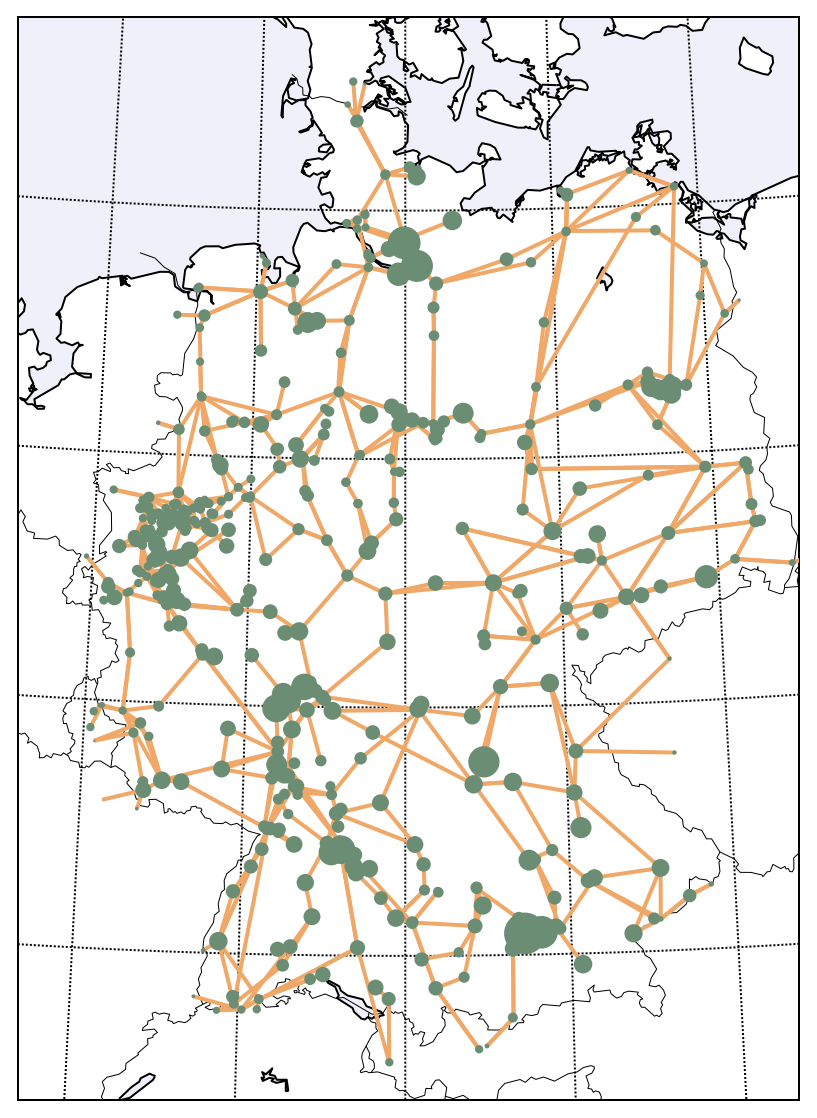

Wall time: 8.78 s


In [134]:
%%time

fig, ax = plt.subplots()
fig.set_size_inches(7,10)
load_distribution = network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum()


if pretty:
    d = {'projection': 'tmerc', 'lon_0':10.0,'lat_0':50.0,'resolution':'i', }
else:
    d = {'resolution':'c', }
network.plot(line_colors='#F0A868',
             bus_colors='#6A8D73',
             bus_sizes=.3*load_distribution,
             ax=ax,
             basemap=d,
             wet_color='#f0f0fa',
             meridian_sep=2.,parallel_sep=2.0)

plt.show()


In [4]:
network.generators.groupby("carrier")["p_nom"].sum()


carrier
Brown Coal       20879.500000
Gas              23913.130000
Geothermal          31.700000
Hard Coal        25312.600000
Multiple           152.700000
Nuclear          12068.000000
Oil               2710.200000
Other             3027.800000
Run of River      3999.100000
Solar            37041.524779
Storage Hydro     1445.000000
Waste             1645.900000
Wind Offshore     2973.500000
Wind Onshore     37339.895329
Name: p_nom, dtype: float64

In [5]:
network.storage_units.groupby("carrier")["p_nom"].sum()

carrier
Pumped Hydro    9179.5
Name: p_nom, dtype: float64

In [6]:
tech = 'Wind Onshore' # in ["Gas","Brown Coal","Hard Coal","Wind Offshore","Wind Onshore","Solar"]

gens = network.generators[network.generators.carrier == tech]
gen_distribution = gens.groupby("bus").sum()["p_nom"].reindex(network.buses.index,fill_value=0.)

#set the figure size first
fig = dict(data=[],layout=dict(width=700,height=700))

fig = network.iplot(bus_sizes=0.05*gen_distribution, fig=fig,
                     bus_text=tech + ' at bus ' + network.buses.index + ': ' + round(gen_distribution).values.astype(str) + ' MW',
                     title=tech + " distribution")   

# Run Linear Optimal Power Flow on the first day of 2011¶

In [7]:
#to approximate n-1 security and allow room for reactive power flows,
#don't allow any line to be loaded above 70% of their thermal rating

contingency_factor = 0.7

network.lines.s_nom = contingency_factor*network.lines.s_nom

In [8]:
#There are some infeasibilities without small extensions                                                                                 
for line_name in ["316","527","602"]:
    network.lines.loc[line_name,"s_nom"] = 1200


#the lines to extend to resolve infeasibilities can
#be found by
#uncommenting the lines below to allow the network to be extended

#network.lines["s_nom_original"] = network.lines.s_nom

#network.lines.s_nom_extendable = True
#network.lines.s_nom_min = network.lines.s_nom

#Assume 450 EUR/MVA/km
#network.lines.capital_cost = 450*network.lines.length

In [9]:
group_size = 4

solver_name = "glpk"

print("Performing linear OPF for one day, {} snapshots at a time:".format(group_size))

network.storage_units.state_of_charge_initial = 0.

for i in range(int(24/group_size)):
    #set the initial state of charge based on previous round
    if i>0:
        network.storage_units.state_of_charge_initial = network.storage_units_t.state_of_charge.loc[network.snapshots[group_size*i-1]]
    network.lopf(network.snapshots[group_size*i:group_size*i+group_size],
                 solver_name=solver_name,
                 keep_files=True)
    network.lines.s_nom = network.lines.s_nom_opt

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


Performing linear OPF for one day, 4 snapshots at a time:


c:\dev\grid-analysis\venvwin\lib\site-packages\pypsa\components.py:758: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\testing\tmp6m4wjmsk.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\testing\tmpnr2hqm0x.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\testing\\tmpyf_xvovg.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1449687.2501478
  Upper bound: 1449687.2501478
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.187445878982544
# ----------------------------------------------------------
#   Solution Information
# -------

c:\dev\grid-analysis\venvwin\lib\site-packages\pypsa\opf.py:1207: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


c:\dev\grid-analysis\venvwin\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\testing\tmpy5x8hrxz.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\testing\tmpa5irv0l1.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\testing\\tmpw9icp8he.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 873763.90232936
  Upper bound: 873763.90232936
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.020920753479004
# ----------------------------------------------------------
#   Solution Information
# -------

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\testing\tmpqi3141z4.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\testing\tmphk8t3222.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\testing\\tmpk_o0lbwr.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 790786.594882226
  Upper bound: 790786.594882226
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 4.203757047653198
# ----------------------------------------------------------
#   Solution Information
# -----

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\testing\tmp8u62135e.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\testing\tmpnx9lr3n8.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\testing\\tmpfy8qlbun.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1455232.6782739
  Upper bound: 1455232.6782739
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 4.794180154800415
# ----------------------------------------------------------
#   Solution Information
# -------

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\testing\tmp6kjyqh3d.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\testing\tmpfxpdvu9r.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\testing\\tmpcbqk85eu.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2647879.91201594
  Upper bound: 2647879.91201594
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 2.529233932495117
# ----------------------------------------------------------
#   Solution Information
# -----

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\testing\tmp6wldzg3w.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\testing\tmpbb922pmr.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\testing\\tmpptqbh_l0.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2139360.37637067
  Upper bound: 2139360.37637067
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 2.6309611797332764
# ----------------------------------------------------------
#   Solution Information
# ----

# Reactive power flow

In [13]:
#For the PF, set the P to the optimised P
network.generators_t.p_set = network.generators_t.p_set.reindex(columns=network.generators.index)
network.generators_t.p_set = network.generators_t.p

In [14]:
#set all buses to PV, since we don't know what Q set points are
network.generators.control = "PV"

#set slack
#network.generators.loc["1 Coal","control"] = "Slack"


#Need some PQ buses so that Jacobian doesn't break
f = network.generators[network.generators.bus == "492"]
network.generators.loc[f.index,"control"] = "PQ"

In [15]:
print("Performing non-linear PF on results of LOPF:")

info = network.pf()

c:\dev\grid-analysis\venvwin\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


INFO:pypsa.pf:Slack bus for sub-network 0 is 1
c:\dev\grid-analysis\venvwin\lib\site-packages\pypsa\components.py:758: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
         

Performing non-linear PF on results of LOPF:


INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.059870 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.067820 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.066842 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.064825 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.066856 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.085772 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.089758 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.151570 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.150595 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.123669 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iteration

In [16]:
#any failed to converge?
(~info.converged).any().any()

False

In [27]:
print("With the non-linear load flow, there is the following per unit loading\nof the full thermal rating:")
print((network.lines_t.p0.loc[now].abs()/network.lines.s_nom*contingency_factor).describe())

With the non-linear load flow, there is the following per unit loading
of the full thermal rating:
count    8.520000e+02
mean     1.929981e-01
std      1.861680e-01
min      1.903464e-15
25%      5.004567e-02
50%      1.345684e-01
75%      2.714891e-01
max      8.402923e-01
dtype: float64


In [24]:
#Get voltage angle differences

df = network.lines.copy()

for b in ["bus0","bus1"]:
    df = pd.merge(df,network.buses_t.v_ang.loc[[now]].T,how="left",
         left_on=b,right_index=True)

s = df[str(now)+"_x"]- df[str(now)+"_y"]

In [25]:
print("The voltage angle differences across the lines have (in degrees):")
print((s*180/np.pi).describe())

The voltage angle differences across the lines have (in degrees):
count    852.000000
mean      -0.021854
std        2.382989
min      -12.183990
25%       -0.464599
50%        0.001726
75%        0.528729
max       17.959258
dtype: float64


In [26]:
#plot the reactive power

now = network.snapshots[0]

q = network.buses_t.q.loc[now]

bus_colors = pd.Series("red",network.buses.index)
bus_colors[q< 0.] = "blue"

fig = dict(data=[],layout=dict(width=700,height=700))

fig=network.iplot(bus_sizes=2e-1*abs(q),bus_colors=bus_colors,
                  bus_text='Bus ' + network.buses.index + ' Q: ' + q.reindex(network.buses.index).round().astype(str) + ' MVAr',
                  title="Reactive power feed-in (red=+ve, blue=-ve)",fig=fig)

# Needs cufflinks to be installed

In [18]:
#if lines are extended, look at which ones are bigger
#network.lines[["s_nom_original","s_nom"]][abs(network.lines.s_nom - contingency_factor*network.lines.s_nom_original) > 1]

In [20]:
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
p_by_carrier.drop((p_by_carrier.max()[p_by_carrier.max() < 1700.]).index,axis=1,inplace=True)
p_by_carrier.columns


Index(['Brown Coal', 'Gas', 'Hard Coal', 'Nuclear', 'Run of River', 'Solar',
       'Wind Offshore', 'Wind Onshore'],
      dtype='object', name='carrier')

In [21]:
colors = {"Brown Coal" : "brown",
          "Hard Coal" : "black",
          "Nuclear" : "red",
          "Run of River" : "green",
          "Wind Onshore" : "blue",
          "Solar" : "yellow",
          "Wind Offshore" : "cyan",
          "Waste" : "orange",
          "Gas" : "orange"}
#reorder
cols = ["Nuclear","Run of River","Brown Coal","Hard Coal","Gas","Wind Offshore","Wind Onshore","Solar"]
p_by_carrier = p_by_carrier[cols]

In [22]:
#Unfortunately this shows cumulative sums on hover, not the individual contributions
#Blame cufflinks, not us :-)
(p_by_carrier/1e3).iplot(kind="area",fill=True,
                         width=4,
                         yTitle="GW",
                         color=[colors[col] for col in p_by_carrier.columns])

AttributeError: 'DataFrame' object has no attribute 'iplot'

In [5]:
import mpl_toolkits.basemap

In [6]:
pypsa.plot.basemap_present

True

In [33]:
import sys
sys.path

['C:\\dev\\grid-analysis\\notebooks\\testing',
 'c:\\dev\\grid-analysis\\venvwin\\scripts\\python37.zip',
 'C:\\Users\\fonsv\\AppData\\Local\\Programs\\Python\\Python37\\DLLs',
 'C:\\Users\\fonsv\\AppData\\Local\\Programs\\Python\\Python37\\lib',
 'C:\\Users\\fonsv\\AppData\\Local\\Programs\\Python\\Python37',
 'c:\\dev\\grid-analysis\\venvwin',
 '',
 'c:\\dev\\grid-analysis\\venvwin\\lib\\site-packages',
 'c:\\dev\\grid-analysis\\venvwin\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\fonsv\\.ipython']